# Implementation of a SQP for nonlinear optimal control
The goal of this exercise is to implement a SQP solver to solve a nonlinear optimal control problem.

Consider the pendulum below 

<img src='pendulum.png' width="150">

Assuming $m=l=1$, The dynamics of this pendulum is
$$\ddot{\theta} = u - g \sin\theta$$
which can be discretized with the following dynamics
$$\begin{align}\theta_{n+1} &= \theta_n + \Delta t \omega_n\\ 
\omega_{n+1} &= \omega_n + \Delta t (u_n - g \sin\theta_n)\end{align}$$
where $\theta_n$ is the angle of the pendulum with respect to the vertical at time step $n$ and $\omega_n$ its angular velocity. We will use $\Delta t = 0.01$.
The pendulum starts at configuration $\theta_0 = \omega_0 = 0$, i.e. all the way down with zero velocity and we would like to find
an optimal control that will bring it up to $\theta=\pi$ with zero velocities.

To get the pendulum to do this movement, we write the following optimal control problem
$$\begin{align}
& \min_{\theta_n, \omega_n, u_n} \sum_{n=0}^{300} 10(\theta_n - \pi)^2 + 0.1\omega_n^2 + 0.1u_n^2\\
\textrm{subject to}\ \ & \theta_{n+1} = \theta_n + \Delta t \ \omega_n \\
& \omega_{n+1} = \omega_n + \Delta t\ (u_n - g \sin\theta_n)\\
& \theta_0 = \omega_0 = 0
\end{align}$$

## Question 1: write a SQP solver to solve this problem
To do so, please follow these steps:
* Write down the algorithm (in words not in code), i.e. write all the steps you need to take
* Write (in Latex) the gradient of the running cost at a given guess $\bar{x} = [\bar{\theta}_0, \bar{\omega}_0, \bar{u}_0, \bar{\theta}_1, \bar{\omega}_1, \bar{u}_1, \dots, \bar{\theta}_{300}, \bar{\omega}_{300}, \bar{u}_{300}]^T$, i.e. for given values $\bar{\theta}_n, \bar{\omega}_n, \bar{u}_n$ and implement a function that computes it
* Write (in Latex) the Hessian of the running cost at a given guess $\bar{x}$, i.e. for given values $\bar{\theta}_n, \bar{\omega}_n, \bar{u}_n$ and implement a function that computes it
* Assume that the Hessian of the constraints is 0 (i.e. ignore the second order derivatives of the constraints)
* Write (in Latex) a linear approximation of the constraints at a given guess $\bar{x}$ in a form $G(\bar{x}) \Delta x = g(\bar{x})$ (don't forget the constant terms in g) where $\Delta x$ represents a small variation around $\bar{x}$ and implement a function that computes both $G$ and $g$.
* Use these functions to construct the inner linear KKT system that you will solve using Numpy's solve function (this should resemble the KKT system you built in the first homework)
* Implement a function that computes the amount of constraint violation, i.e. the sum of the absolute values of all the constraints (i.e. assuming constraints of the form $c(x) = 0$ we want to compute $|c(x)|$).
* Implement a filter linear search to test if a step should be accepted. You will implement the (simplified) filter line search explained below.
* Terminate the algorithm when you either reached the maximum number of iterations (e.g. 100) or when the KKT optimality conditions $\nabla_x L$ and $\nabla_\lambda L$ are close to 0, e.g. $10^{-4}$.


Once you have a solution, make sure to check that it satisfies the constraints! You can also use the function ``pendulum.animate_robot`` to display the pendulum motion. Please answer the following questions:
1. How many iterations did it take?
2. Plot the solution (angle, velocity and control)
3. Plot the amont of constraint violation per iteration of the solver
4. Plot the cost per iteration of the solver
5. Plot $\alpha$ for each iteration of the solver

### (Simple) filter linear search
Once you have a potential step $p_x$ and associated candidate Lagrange multipliers $p_\lambda$ (from the ``solve`` of the KKT system), you need to find a step $\alpha$ to update your guess of the solution $x_{guess}$ and the Lagrange multipliers $\lambda_{guess}$. We will accept a step that either reduces the amount of constraint violation or reduces the cost.

Let's denote $f(x)$ the cost at $x$ and $|c(x)|$ the amount of constraint violation at $x$. Initialize the variable $f_{best} = \infty$ and $c_{best}=\infty$ at the beginning of the SQP. 

Then do the following during the line search.
1. Set $\rho$ to a number between 0 and 1 (e.g. 0.5) and set $\alpha = 1$
2. If $f(x_{guess} + \alpha p_x) < f_{best}$ then set $f_{best} \leftarrow f(x_{guess} + \alpha p_x)$ and accept the step

   Or 

   If $|c(x_{guess} + \alpha p_x)| < c_{best}$ then set $c_{best} \leftarrow |c(x_{guess} + \alpha p_x)|$ and accept the step
3. If the step was not accepted set $\alpha \leftarrow \rho \alpha$ and go back to Step 2.
4. If the step was accepted update the guess $x_{guess} \leftarrow x_{guess} + \alpha p_x$ and the Lagrange multipliers $\lambda_{guess} \leftarrow (1-\alpha)\lambda_{guess} + \alpha p_{lambda}$

# **Solution**

In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython
import numpy as np
import math

import pendulum

We can solve this using as SQP, i.e taking a linear approximation of the Lagrangian $\nabla_x L$ and $\nabla_\lambda L$:

We get:


\begin{bmatrix} \nabla_{xx}^2 \mathcal{L}(x_k) & \nabla g(x_k)^T \\ \nabla g(x_k) & 0 \end{bmatrix} \begin{pmatrix} p_x \\ p_\lambda \end{pmatrix} = \begin{pmatrix} -\nabla f(x_k) - \nabla g(x_k)^T \lambda_k \\ -g(x_k) \end{pmatrix}


Here $p_x$ and $p_\lambda$ are a small change in $x$ and $\lambda$ values respectively

Taking $p_\lambda = \lambda_k + p_\lambda$ we get:


\begin{bmatrix} \nabla_{xx}^2 \mathcal{L}(x_k) & \nabla g(x_k)^T \\ \nabla g(x_k) & 0 \end{bmatrix} \begin{pmatrix} p_x \\ p_\lambda \end{pmatrix} = \begin{pmatrix} -\nabla(x_k)\\ -g(x_k) \end{pmatrix}

Second derivative of the Lagrangian of x can be approximated to the Hessian of x



### **Calculations**

$\nabla f(x) =\begin{bmatrix} 20(\theta_n - \pi) \\ 0.2\omega_n \\ 0.2u_n \end{bmatrix}$<br>
We can stack this in a matrix to get $\nabla f(x)$ matrix.<br>
$\nabla^2 f(x) =\begin{bmatrix} 20 & 0 & . & . & 0\\ 0 & 0.2 & 0 & . & 0\\  0 & 0 & 0.2 & . & 0 \\  0 & 0 & 0 & . & 0\end{bmatrix}$<br><br>
We can Linearize our constraints using Taylor's series of $g(x)$ to get $\nabla g(x) dx  = - g(x)$<br>
Stacking up each of the contraint approximations in a matrix we get:<br><br>
$\begin{bmatrix} -1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & . & 0 \\ 0 & -1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &. & 0 \\ -1 & -\Delta t & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 &. & 0 \\ \Delta t g cos(\theta_0) & -1 & \Delta t & 1 & 0 & 0 & 0 & 0 & 0 & 0 &. & 0 \\ 0 & 0 & 0 & -1 & -\Delta t & 0 & 1 & 0 & 0 & 0 & . & 0\\ 0 & 0 & 0& \Delta t g cos(\theta_0) & -1 & \Delta t & 0 & 1& 0 & 0 & . & 0 \\ . & .& \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &. & 0\end{bmatrix} \begin{bmatrix}\theta_0 \\ \omega_0 \\ u_0 \\ \theta_1 \\ \omega_1 \\ u_1 \\ . \\ u_n\end{bmatrix} = -g(x)$

In [2]:
#Gradient of x

def grad_f(x):
    df = np.zeros(x.shape[0])
    for i in range(x.shape[0]//3):
        df[3*i] = 20*(x[3*i] - np.pi)
        df[3*i + 1] = 0.2 * x[3*i + 1]
        df[3*i + 2] = 0.2 * x[3*i + 2]

    return df

#Hessian of f
def hessian(x):
    df = np.zeros((x.shape[0], x.shape[0]))
    for i in range(x.shape[0]//3):
        df[3*i, 3*i] = 20
        df[3*i + 1, 3*i + 1] = 0.2
        df[3*i + 2, 3*i + 2] = 0.2

    return df

#g(x) and grad of g(x)
def g(x):
    n = x.shape[0]//3
    g_1 = np.zeros((2*n))
    g_1[0] = x[0]
    g_1[1] = x[1]
    for i in range(1, n):
        g_1[2*i] = -x[3*(i-1)] - pendulum.dt*x[3*(i-1) + 1] + x[3*(i-1) + 3]
        g_1[2*i + 1] = pendulum.dt*pendulum.g*np.sin(x[3*(i-1)]) - x[3*(i-1) + 1] - pendulum.dt*x[3*(i-1) + 2] + x[3*(i-1) +4]
    
    return g_1

def grad_g(x):
    n = x.shape[0]//3
    b = np.zeros((2*n, 3*n))
    b[0][0] = -1
    b[1][1] = -1
    for i in range(1, n):
        b[2*i:2*i+2, 3*(i-1): 3*(i-1)+5] = [[-1, -pendulum.dt, 0, +1, 0],[(pendulum.dt*pendulum.g*math.cos(x[3*(i-1)])), -1, -pendulum.dt, 0, 1]]

    return b

In [3]:
#Checking the runnning cost by adding up n+1 times
def f(x):
    n = x.shape[0]//3
    cost = 0
    for i in range(n):
        cost += 10*((x[i] - math.pi)**2) + 0.1*(x[i+1]**2) + 0.1*(x[i+2]**2)

    return cost

#Checking the constraint violation - sum of absolute values of all constraints g(x)
def c(x):
    g_x = g(x)
    constraint_violation = 0
    for i in range(2, g_x.shape[0]):
        constraint_violation += abs(g_x[i])

    return constraint_violation

#Filter line search
def line_search(x , px , f_best, c_best):
    t = 0.5
    a = 1

    while True:
        print(f"searching for best a, current a is {a}")
        if a < 10e-5:
            return a, f_best, c_best
        
        #Calculate running cost with x = x_old + a*px and seeing if it is better than before
        f_t = np.linalg.norm(f(x + a*px))
        if f_t < f_best:
            f_best = f_t
            return a, f_best, c_best
        
        #Calculate total constraint violation with x = x_old + a*px and seeing if it is better than before
        c_t = c(x + a*px)
        if c_t < c_best:
            c_best = c_t
            return a, f_best, c_best
    
        #Updating alpha to t*alpha and repeating till condition is met (0 < t < 1)
        a = t*a

In [4]:
#Optimizing 
timesteps = 301
n_vars = 3
n_total = n_vars*timesteps
n_constraints = timesteps*2

#initialise best running cost and conostraint violation to infiinity just for first iteration in filter line search
f_best = np.inf
c_best = np.inf

alphas = []
costs = []
constr_vio = []
iters = 0

#Start with some arbitrary value of x and lambda
x = np.zeros((n_total, 1))
lmbda = np.zeros((n_constraints, 1))
print(f"Num of timesteps: {timesteps}")

for i in range(20):

    iters += 1
    #Getting all the elements for KKT matrix
    hess = hessian(x)
    hess.shape
    gradient_f = grad_f(x)
    g_x = g(x)
    gradient_g = grad_g(x)

    #Construct KKT matrix
    kkt = np.zeros((n_total + n_constraints, n_total + n_constraints))
    kkt[0:n_total, 0:n_total] = hess
    kkt[0:n_total, n_total:] = gradient_g.transpose()
    kkt[n_total:, 0:n_total] = gradient_g

    rhs = np.zeros((n_total + n_constraints, 1))
    rhs[0:n_total, 0] = -gradient_f
    rhs[n_total:n_total + n_constraints, 0] = -g_x

    #Using numpy . solve to solve the system of equations, divide the solution into px and plambda
    p = np.linalg.solve(kkt, rhs)
    px = p[:n_total]
    plambda = p[n_total:]


    #use line search to find the best value of alpha, by checking when running cost or constraint violation is lower than previous iteration
    a, f_best, c_best = line_search(x, px, f_best, c_best)
    print(f"best alpha is {a}\n")

    #Update x values and Lambda values
    x = x + a*px
    lmbda = (1-a)*lmbda + a*plambda

    #Threshold for when to stop optimizing is when lagrangian is minimized and constraints are minimized or when maximum iterations are reached
    lagrangian_x = grad_f(x) + grad_g(x).transpose()@lmbda
    lagrangian_lmbda = g(x)

    print(f"Iteration number{i}")

    lag_x_sum = np.abs(np.sum(lagrangian_x))
    lag_lmbda_sum = np.sum(np.abs(lagrangian_lmbda))

    constr_vio.append(lag_lmbda_sum)
    alphas.append(a)
    costs.append(np.sum(f(x)))

    print(f"Min lagrangian is {lag_x_sum}\nConstraints sum is {lag_lmbda_sum}\n Cost is {np.sum(f(x))}")
    if lag_x_sum < 0.0001 and lag_lmbda_sum < 0.0001:
        break


Num of timesteps: 301


C:\Users\megh2\AppData\Local\Temp\ipykernel_50100\1488804838.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  df[3*i] = 20*(x[3*i] - np.pi)
C:\Users\megh2\AppData\Local\Temp\ipykernel_50100\1488804838.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  df[3*i + 1] = 0.2 * x[3*i + 1]
C:\Users\megh2\AppData\Local\Temp\ipykernel_50100\1488804838.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  df[3*i + 2] = 0.2 * x[3*i + 2]
C:\Users\megh2\AppData\Local\Temp\ipyk

searching for best a, current a is 1
best alpha is 1

Iteration number0
Min lagrangian is 7429020.261600409
Constraints sum is 21.64851272307056
 Cost is 88111.08425341504
searching for best a, current a is 1
best alpha is 1

Iteration number1
Min lagrangian is 2149704.2194318944
Constraints sum is 17.97498693473057
 Cost is 95179.5892296646
searching for best a, current a is 1
best alpha is 1

Iteration number2
Min lagrangian is 8135.579199219819
Constraints sum is 0.05885055939413689
 Cost is 107125.46336800285
searching for best a, current a is 1
best alpha is 1

Iteration number3
Min lagrangian is 396.938720860755
Constraints sum is 4.5758310455588445e-06
 Cost is 107398.14920816883
searching for best a, current a is 1
best alpha is 1

Iteration number4
Min lagrangian is 19.354452394429245
Constraints sum is 1.0160766657251515e-08
 Cost is 107411.71592069796
searching for best a, current a is 1
best alpha is 1

Iteration number5
Min lagrangian is 0.9390218849985104
Constraints sum 

Converged in 10 iterations

In [5]:
tf = []
of = []
uf = []
for i in range(0, x.shape[0], 3):
    tf.append(x[i])
    of.append(x[i+1])
    uf.append(x[i+2])
tf = np.array(tf)
of = np.array(of)
uf = np.array(uf)

In [6]:
# dt is defined here
print(f'we use the following dt={pendulum.dt}')

# and g here
print(f'we use the following g={pendulum.g}')

# you can use this animate function to display what the pendulum would do for a given sequence of control
x_init = np.array([[0],[0]])
pendulum.animate_robot(x_init, uf.T)

we use the following dt=0.01
we use the following g=9.81


<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAMXVtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzE5MSA0NjEzYWMzIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyNCAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE5
IGxvb2thaGVhZF90aHJlYWRzPTMgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DNVliIQAP//+92ifAptaQ3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAAVt6RlhkJ0L/JiAAAFfACy
BmSZ6XFJE4AKCdnVuDJz6YRA9aXK+D92cTMu+hvWEgrm6VgN+NN58xr5ENbD+oIFbJh3Hp5aaZ7q
A6T9bic4xbRxQpgkTkdJXn7mxrIyGimVgSkYPxFhDkBW2ULOVc3poxMubwa8KN+BHPPpeuCVceyT
K8Sutw9A6fdPtZ/8tSIN4rY0xxRToEK/HoC502qtOxtzT5Rshcw28vw//QkgQVxA2eXnAUAxIAOb
GLPoKfXjk5pFs/rBKwvOmK74JvarEOzfC34c3bf3d3EXiENvbfmgN445qoqXG0rX23WzVwbHgmtm
Q3VcS412auklSczhDcDlDnRxPyboQULE4aoDSPdIVIwcHKRFurb7GI3GohEQb37fenqBMoKtvGDc
ZQX/K0/AIDssxoDtSaQ9lJ/bFa/O6nXXKcpTKr+GKYKpYMHoFtBt5JcYBX6JL7HvFE23bTVFiJ2i
L2/SIrRv7xzo1biqog9FulZ9vPln70zwy1hTxAooHAEnuGRm+741AFjGQ4ELGQ/NJWF2pLTK+Ad1
vD8Pbev5HVEAb4r90LB+BOzJj0e61/EbH1E8xefu3/RleFlNwAww0NXSCQNCmpgBD9/cGehT78cf
fdZeSYfh4j42j3K8r7hTcJ8XPTimB/5TR2ewjoZ69kvbn0UVGO8BXBm5gBaaLUYjKX3AFjv/WSAB
1l9wgVwA4xaXuWAAAAMAAA0+Mx3VFhjCJ35zx2KPVXy/X//MBYzpt/ACmFNpYWvW4jC2HqbrV04K
tyiKfsqxHioMxH4PoOwM6Qc0VhicD8vNu8KxWQfc4eMl6XZQHH0Je/NllYEvtdtiOEp6TMoeHka/
dceDqNaR0raHZ7ptRX5klMO2E+/CdWCjEVZYZOL13BjJPtiXXYVAMRjEQDJbQywgRhPDZBP7SLEl
ygxcyZj6w2GBrxT1XThJPF3R50QInTtoXQA87gfHskEbov+Ar48TFGGmNYmMWsntuuZr/DowAGtR
3h6xwmo90/pEIR7DRszTyPSabgp5qZaFzi0xyqaBfXian/xuhhmOFA1YjDB8Fce0aUBwz5khlvYd
ggnMwuwC8SpP+imOj4+E6W2gda/p1Cy2nd0QMWdCtKaxi7auvDxPjoYWkc4pKAjW4bONBytSMqAA
AAMAAAMABdWM7EIQbX46gwWRhplLPIs7QIzJ3v7LbkMO7zmoZu3zqrsmGY0+TJXjy5CiQdFq4J4C
s1+X3j5nm+QAqoO7xT85N0yBXH7EJ+awnyC+OG6IAVmlzYAJUA3Zl2StFtGHCk1XJ+ly3WiYkC9Y
V5XjoWdP8qbdS2jGk2D+HmiXs+e5Au4x8aF2So32xIk/j9uIm2ZNEuXWd16RGX7bAfjEEWTXqGYB
bT4qp0EqkBs/WElZ55/Q/no7MUZrMcZTD+F82q2mBRgH0g5gidWOq8Iq0ceDE78pzB9dLaX5NCox
9cgH3ik+onHGMaYs8fLsY4Pc6DBfi4XNvnedUhU1T15Kjzw5LFUxh1S2L8PrtZDBPvH2vj9RK+UQ
LBmwF5ezChCEptTTXlvz7t7WQym7qwwNByZtAKJ6XJ8A2MQkeKzj+Bpu1YjrlrBVhHUM6u9ZLe8D
ZVFvsvP2N9t+Rg8ydyuSpkTLCS7TyB7xchC+/OJQxLXDOuSdLZ7I7WOOP1bb01BFPdMU337GTZng
Iu0vN5ZsBGxVj4KHzDen3d/vHHc8+CCao5w+lH7GGB//2DswifAEpUMeKUOWu8E6hr451ZwdpNLA
SzF4ajIqcLsSju5W4fBmeZGxR0OEJqh2Yqkv6YyCG5KuRPJAr+Cea2zcnLwybpdewyFmjiHWYz5b
bg9Hinjf5v7gblkp8QH9kWjwNxYZCQ6wG963CfMfscfV26tpO6oOEBVldqWCpSEeFD6RB25TyGPs
K/T3uvprsb6lKxv26Q8YBcGT3r/kdYmmtLRzIrefx9HhIsLy/dGe2Yk9lI3G0ZZ4012Jovutff1g
0QAR7A9qH5lhcOPTnU8TJzyUjhefAjHfdMQFqrtWNPMIwigmkd9sNHqGKVV7sI9zwkalCaKh31ZP
xk0HsnL1ptiXEt/VAWdthRsdFcwxhW3V7vUrMRetpxQ+QveoIbfmCRan5kwN+uNjwHP5/yHU5oYw
4NkgsG6YTpvJaR7jtsKE/vdi/e2NhW+0BXEXwqlHmpMhhTfpQQQ/g1acEkqlYwOmItjR0xavqw/l
4epMas47Q3gSFvIschyszGyxIX/cOa8u95KbIh1Mv5lxs+fADGo3IhH0llRSyOdfWL07bQEGKy+N
wuqsweq+5HZTKfDTbB+xtWQsXzBRdlBXv5vAAAOzfGsYjALPh5IyM8ug5vYLu/AAQOzKSG6YAAJd
DyLATAf1XwYZKO8+iYtZNu10R5XkwRIyPDow58Fl6COxzljLp8ZBuU39YmwQCZ5n1OZ5iYxKuJM9
g/OgnLfsf5enYu9XVCsMSJqhNDoof+MXwAg5lkoItDL4BD6pME4/X7HVeU3Qi0CSpsoi0+4Vxlur
4cf2NA6hN4uylDIUr69FvYatygLGre2n4bTrR4+hNrc/iXimQWZLFGJux+wbl9zLaKZTzzERrq/W
kV8xn+IAq4KjqC47kUybC2HNHNTChPkIFsywjq6EKSvKW5QtZ7tDnfnr95icaaE4+qVKkOjh7qXb
jU5bovU2WQXtimyZVPam3Zz9dLd+5mg4X6BaQFtyZPPDTn/4gPhqla3c8v//7u3NUS4dUFpovpZn
A07arf45p7U04c0kLh78n5MNw+MN/lGtR88un12aw9LZEnoYW71+QhPZHkRNMDPVcfuA9ocrszO6
i/2RiKNLTYtWNMtp8flk6

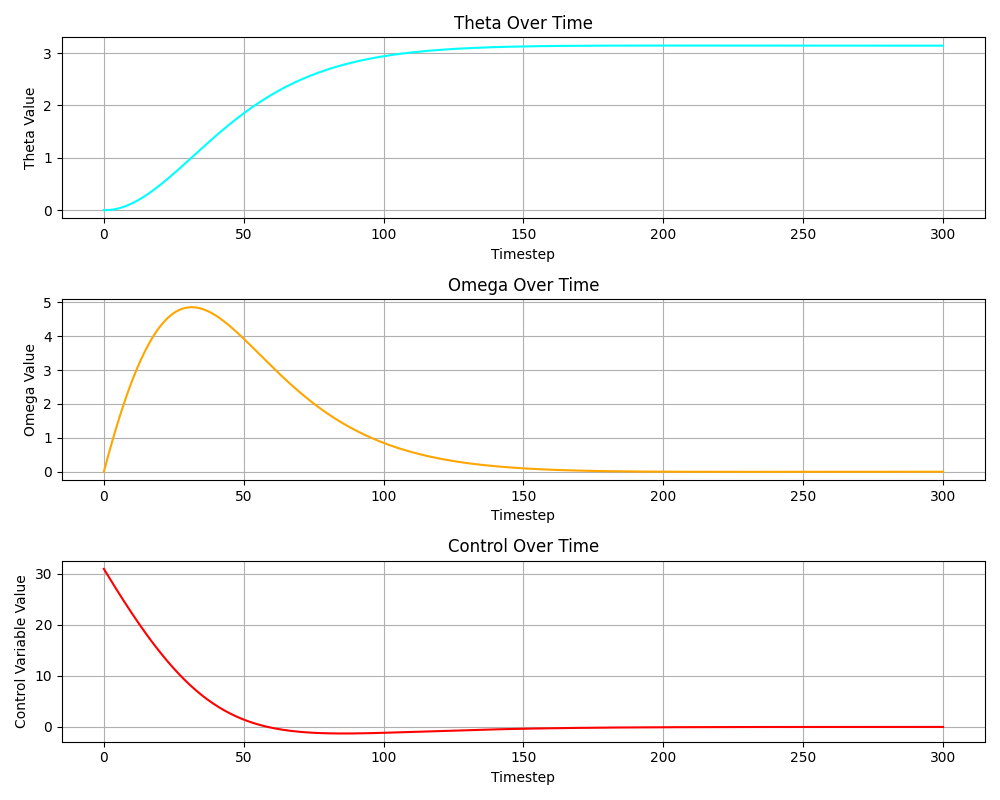

In [7]:
#To plot the graph of control u with each timestep
timesteps = list(range(301))
theta = tf
omega = of
control = uf

fig, axs = plt.subplots(3, 1, figsize=(10, 8))  # 2 rows, 1 column

# Plot the first control variable
axs[0].plot(timesteps, theta, linestyle='-', color='cyan')
axs[0].set_title('Theta Over Time')
axs[0].set_xlabel('Timestep')
axs[0].set_ylabel('Theta Value')
axs[0].grid()

# Plot the second control variable
axs[1].plot(timesteps, omega, linestyle='-', color='orange')
axs[1].set_title('Omega Over Time')
axs[1].set_xlabel('Timestep')
axs[1].set_ylabel('Omega Value')
axs[1].grid()

axs[2].plot(timesteps, control, linestyle='-', color='red')
axs[2].set_title('Control Over Time')
axs[2].set_xlabel('Timestep')
axs[2].set_ylabel('Control Variable Value')
axs[2].grid()


plt.tight_layout()
plt.show()

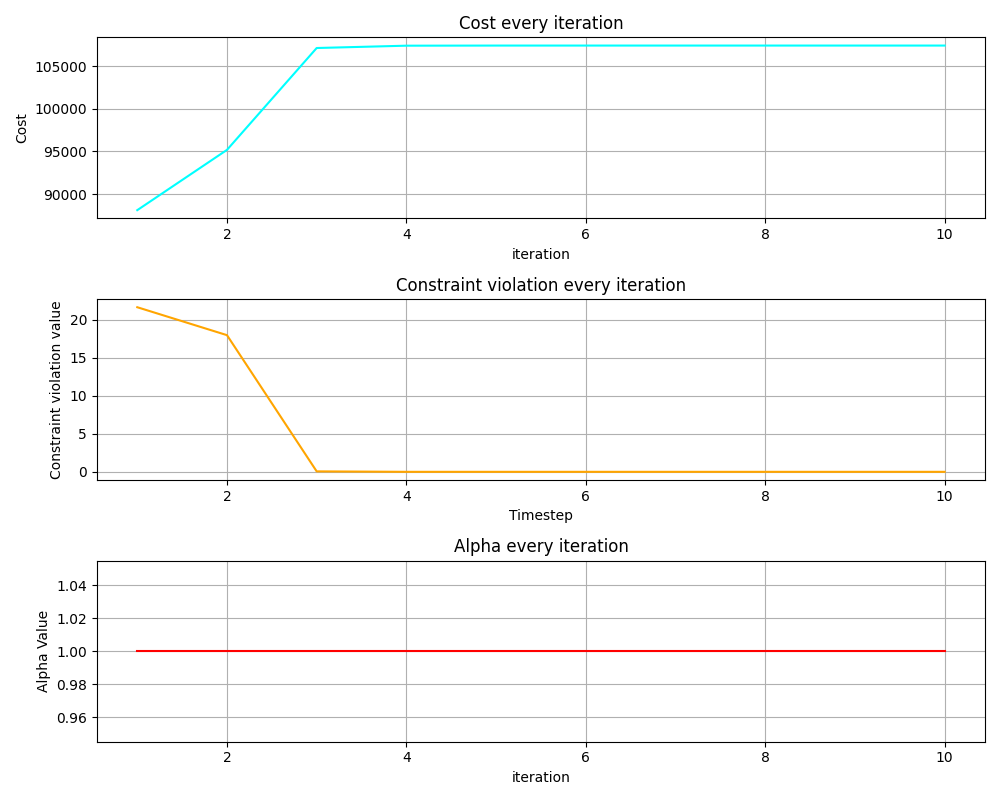

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(10, 8))  # 2 rows, 1 column
iters_lst = list(range(1, iters + 1))

# Plot the first control variable
axs[0].plot(iters_lst, costs, linestyle='-', color='cyan')
axs[0].set_title('Cost every iteration')
axs[0].set_xlabel('iteration')
axs[0].set_ylabel('Cost')
axs[0].grid()

# Plot the second control variable
axs[1].plot(iters_lst, constr_vio, linestyle='-', color='orange')
axs[1].set_title('Constraint violation every iteration')
axs[1].set_xlabel('Timestep')
axs[1].set_ylabel('Constraint violation value')
axs[1].grid()

axs[2].plot(iters_lst, alphas, linestyle='-', color='red')
axs[2].set_title('Alpha every iteration')
axs[2].set_xlabel('iteration')
axs[2].set_ylabel('Alpha Value')
axs[2].grid()


plt.tight_layout()
plt.show()

It is important to know that although the cost itself increased from out initial random guess, it did so only to satisfy the given constraints and reach the optimal solution.